<a href="https://colab.research.google.com/github/CameronLarsonFLT/PyTorch_FP_Prediction/blob/main/PyTorch_FP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/CameronLarsonFLT/PyTorch_FP_Prediction/main/FPs.png" width="450" align="right">

##PyTorch FP Property Predictor

> **Example script** demonstrating how to:
- Retrieve fluorescent protein (FP) data from the **FPbase REST API**
- Train a simple **PyTorch neural network**
- Predict key **spectral / photophysical properties** from an **amino-acid sequence**

**Inputs:** `protein sequence (AA)`  
**Outputs:** `ex_max`, `em_max`, `brightness`, `pKa`, `stokes_shift`

Predicting property: em_max
Device: cuda
Fetching https://www.fpbase.org/api/proteins/?parent_organism=6100&format=json …
Usable samples: 251
Max sequence length in dataset: 486
Using minibatches: batch_size=32 | steps/epoch=8


Training:   0%|          | 0/3000 [00:00<?, ?epoch/s]

FP_Seq predicted em_max: 510.450


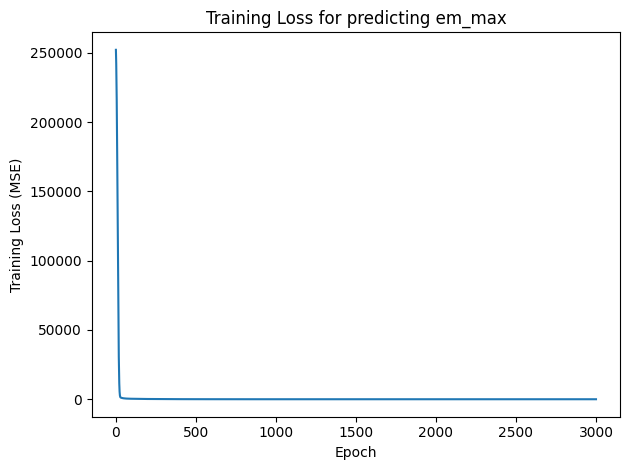

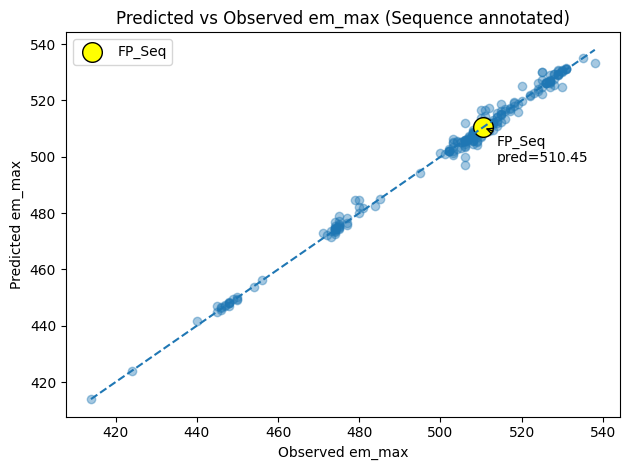

Training complete.


In [4]:
"""
Example script demonstrating how to retrieve fluorescent protein data from the
FPbase REST API and train a simple neural network using PyTorch to predict
various spectral or photophysical properties from the amino-acid sequence.
"""

import os
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import trange
from torch.utils.data import TensorDataset, DataLoader

#@markdown ---
#@markdown ## Property selection
#@markdown **Accepted values for `PROPERTY_NAME`:**
#@markdown
#@markdown - **Spectral**
#@markdown   - `ex_max` — excitation maximum *(nm)*
#@markdown   - `em_max` — emission maximum *(nm)*
#@markdown   - `stokes_shift` — excitation/emission separation *(nm)*
#@markdown - **Photophysics**
#@markdown   - `brightness` — FPbase brightness
#@markdown   - `pka` — chromophore pKa
#@markdown ---

PROPERTY_NAME = "em_max"  #@param {type:"string"}


Fluorescent_Protein_Seq = "MVSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLSLKLISTTGKLPVPWPTLVTTLSYGQMVFARYPDNMKQHDFFKSAMPEGYVQERTISFEDDGYYKTRAEVKFEGDTLVNRIVLKGIDFKEDGNILGHNLEYNFNSHNVYITADKQKNGIKANFKIRHNVEDGGVQLADHYQQNTPIGDGPVLLPDNHYLSIQSKLSKDPNEKRDHMVLKERVTAAGITHDMNELYK"  #@param {type:"string"}

#@markdown ---
#@markdown **Frequently used Taxonomy IDs**
#@markdown - `6100`  *(Aequoria victoria)*
#@markdown - `86600` *(Discosoma sp)*
#@markdown - `6118`  *(Entacmaea quadricolor)*
#@markdown
#@markdown - **Leave Blank to Train on Full FPbase.org Sequence Data**
#@markdown ---
PARENT_ORGANISM = 6100  #@param {type:"integer"}

#@markdown ---

#@markdown **Epochs** *(recommended: 5000 for Spectral Properties)*
#@markdown ---
EPOCHS = 3000  #@param {type:"integer"}

#@markdown **Mini-batch size** *(recommended: 16–64; 0 = full batch)*
BATCH_SIZE = 32  #@param {type:"integer"}


LR = 1e-3

#@markdown ---

EXCLUDE_TERMS = ("channelrhodopsin", "rcamp", "gcamp2", "cp-mkate", "cegfp")
AMINO_ALPHABET = "ACDEFGHIKLMNPQRSTVWY"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# -----------------------------------------------------------------------------
# FPbase retrieval + preprocessing
def fetch_fpbase_proteins(parent_organism) -> list:
    """Retrieve proteins for a given parent organism (taxid) from the FPbase API.
    If parent_organism is None or blank, returns the full dataset.
    """
    proteins: list = []
    parent_organism = "" if parent_organism is None else str(parent_organism).strip()
    if parent_organism.lower() in ("", "none", "null"):
        parent_organism = ""

    if parent_organism:
        if not parent_organism.isdigit():
            raise ValueError(f"PARENT_ORGANISM must be numeric or blank. Got: {parent_organism!r}")
        url = f"https://www.fpbase.org/api/proteins/?parent_organism={parent_organism}&format=json"
    else:
        print("TRAINING ON FULL FPBASE.ORG SEQUENCE DATA")
        url = "https://www.fpbase.org/api/proteins/?&format=json"

    while url:
        print(f"Fetching {url} …")
        resp = requests.get(url, timeout=60)
        resp.raise_for_status()
        data = resp.json()

        # FPbase sometimes returns a list; sometimes paginated dict with "results"
        if isinstance(data, list):
            proteins.extend(data)
            break

        results = data.get("results", [])
        proteins.extend(results)
        url = data.get("next")

    return proteins


def compute_stokes_shift(protein: dict) -> float | None:
    """Compute Stokes shift (em_max - ex_max) for the first state with both values."""
    for state in protein.get("states", []) or []:
        ex = state.get("ex_max")
        em = state.get("em_max")
        if ex is not None and em is not None:
            try:
                return float(em) - float(ex)
            except Exception:
                return None
    return None


def extract_property(protein: dict, property_name: str) -> float | None:
    """Extract a scalar property from a protein record."""
    if property_name == "stokes_shift":
        return compute_stokes_shift(protein)
    states = protein.get("states", [])
    if states and isinstance(states, list):
        return states[0].get(property_name)
    return None


def one_hot_encode_sequence(seq: str, max_len: int, alphabet: str = AMINO_ALPHABET) -> np.ndarray:
    """One-hot encode an amino acid sequence up to max_len. Extra positions remain zeros."""
    aa_to_idx = {aa: i for i, aa in enumerate(alphabet)}
    encoding = np.zeros((max_len, len(alphabet)), dtype=np.float32)
    for i, aa in enumerate(seq[:max_len]):
        idx = aa_to_idx.get(aa)
        if idx is not None:
            encoding[i, idx] = 1.0
    return encoding


# -----------------------------------------------------------------------------
# Model
class PropertyPredictor(nn.Module):
    """A simple feed-forward regressor from one-hot sequences to a scalar property."""
    def __init__(self, input_len: int, alphabet_size: int, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_len * alphabet_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


# -----------------------------------------------------------------------------
# Model bundle save/load (for reuse in later cells)
def save_model_bundle(path: str, model: nn.Module, *, max_len: int, amino_alphabet: str,
                      property_name: str, parent_organism, hidden_dim: int = 64) -> None:
    os.makedirs(os.path.dirname(path), exist_ok=True)
    bundle = {
        "state_dict": model.state_dict(),
        "max_len": int(max_len),
        "amino_alphabet": str(amino_alphabet),
        "property_name": str(property_name),
        "parent_organism": parent_organism,
        "hidden_dim": int(hidden_dim),
    }
    torch.save(bundle, path)
    # print(f"Saved model bundle to: {path}")


# -----------------------------------------------------------------------------
# Run: fetch -> train -> save -> plots
print(f"Predicting property: {PROPERTY_NAME}")
print(f"Device: {DEVICE}")

# Where bundle will go (depends on property + parent organism)
MODEL_DIR = "models"
MODEL_PATH = os.path.join(
    MODEL_DIR,
    f"fp_{PROPERTY_NAME}_parent{PARENT_ORGANISM if (PARENT_ORGANISM not in [None, '']) else 'ALL'}.pt"
)
# print(f"Bundle path: {MODEL_PATH}")

proteins = fetch_fpbase_proteins(parent_organism=PARENT_ORGANISM)
proteins = [
    p for p in proteins
    if not any(term in (p.get("name") or "").lower() for term in EXCLUDE_TERMS)
]

samples: list[tuple[str, float]] = []
for protein in proteins:
    seq = protein.get("seq")
    value = extract_property(protein, PROPERTY_NAME)
    if seq and value is not None:
        try:
            samples.append((seq, float(value)))
        except Exception:
            pass

if not samples:
    raise RuntimeError(f"No valid samples retrieved for property '{PROPERTY_NAME}'.")

max_len = max(len(seq) for seq, _ in samples)
print(f"Usable samples: {len(samples)}")
print(f"Max sequence length in dataset: {max_len}")

X = np.stack([one_hot_encode_sequence(seq, max_len, AMINO_ALPHABET) for seq, _ in samples])
y = np.array([val for _, val in samples], dtype=np.float32)

X_tensor = torch.tensor(X, dtype=torch.float32).to(DEVICE)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(DEVICE)

HIDDEN_DIM = 64
model = PropertyPredictor(input_len=max_len, alphabet_size=len(AMINO_ALPHABET), hidden_dim=HIDDEN_DIM).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=float(LR))

use_minibatch = (BATCH_SIZE is not None) and (int(BATCH_SIZE) > 0)
if use_minibatch:
    bs = int(BATCH_SIZE)
    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=bs, shuffle=True, drop_last=False)
    print(f"Using minibatches: batch_size={bs} | steps/epoch={len(loader)}")
else:
    loader = None
    print("Using full-batch training.")

loss_history = []
pbar = trange(int(EPOCHS), desc="Training", unit="epoch", leave=True, colour = 'cyan')

for epoch in pbar:
    model.train()

    if use_minibatch:
        running_loss = 0.0
        n_samples = 0

        for xb, yb in loader:
            optimizer.zero_grad(set_to_none=True)
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            bsz = xb.size(0)
            running_loss += loss.item() * bsz
            n_samples += bsz

        epoch_loss = running_loss / max(1, n_samples)
        loss_history.append(epoch_loss)
        pbar.set_postfix(loss=f"{epoch_loss:.4f}")

    else:
        optimizer.zero_grad(set_to_none=True)
        preds = model(X_tensor)
        loss = criterion(preds, y_tensor)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        pbar.set_postfix(loss=f"{loss.item():.4f}")

# Save bundle for later reuse
save_model_bundle(
    MODEL_PATH,
    model,
    max_len=max_len,
    amino_alphabet=AMINO_ALPHABET,
    property_name=PROPERTY_NAME,
    parent_organism=PARENT_ORGANISM,
    hidden_dim=HIDDEN_DIM,
)

# In-sample predictions
model.eval()
with torch.no_grad():
    predictions = model(X_tensor).squeeze().detach().cpu().numpy()

# Predict user-provided FP sequence (annotation)
fp_enc = one_hot_encode_sequence(Fluorescent_Protein_Seq, max_len, AMINO_ALPHABET)
fp_tensor = torch.tensor(fp_enc, dtype=torch.float32).unsqueeze(0).to(DEVICE)
with torch.no_grad():
    fp_pred = float(model(fp_tensor).squeeze().item())
print(f"FP_Seq predicted {PROPERTY_NAME}: {fp_pred:.3f}")

# Plot training loss
plt.figure()
plt.plot(range(1, int(EPOCHS) + 1), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title(f"Training Loss for predicting {PROPERTY_NAME}")
plt.tight_layout()
plt.show()

# Plot predicted vs observed (in-sample)
plt.figure()
plt.scatter(y, predictions, alpha=0.4)
min_val = float(min(y.min(), predictions.min(), fp_pred))
max_val = float(max(y.max(), predictions.max(), fp_pred))
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")

# Place FP_Seq on diagonal for visibility
plt.scatter([fp_pred], [fp_pred], s=200, marker="o", edgecolors="k", label="FP_Seq", color="yellow")
plt.annotate(
    f"FP_Seq\npred={fp_pred:.2f}",
    xy=(fp_pred, fp_pred),
    xytext=(10, -25),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
)

plt.xlabel(f"Observed {PROPERTY_NAME}")
plt.ylabel(f"Predicted {PROPERTY_NAME}")
plt.title(f"Predicted vs Observed {PROPERTY_NAME} (Sequence annotated)")
plt.legend()
plt.tight_layout()
plt.show()

# Expose trained objects for the next cell (optional convenience)
TRAINED_MODEL = model
TRAINED_MAX_LEN = max_len
TRAINED_ALPHABET = AMINO_ALPHABET
TRAINED_PROPERTY = PROPERTY_NAME
TRAINED_MODEL_PATH = MODEL_PATH

print("Training complete.")
# print(f"Bundle path: {MODEL_PATH}")


<img src="https://raw.githubusercontent.com/CameronLarsonFLT/PyTorch_FP_Prediction/main/FP_Alternate.png" width="550" align="right">


##PyTorch Global Amino Acid Search

**Determines Impact of Mutations on Defined Property**

**Properties:** `ex_max`, `em_max`, `brightness`, `pKa`, `stokes_shift`

Using in-memory trained model.

Template predicted em_max: 506.947632

M1A: predicted em_max = 512.520020   Δ=+5.572388
M1C: predicted em_max = 504.686127   Δ=-2.261505
M1D: predicted em_max = 506.604462   Δ=-0.343170
M1E: predicted em_max = 504.677704   Δ=-2.269928
M1F: predicted em_max = 504.674713   Δ=-2.272919
M1G: predicted em_max = 504.679352   Δ=-2.268280
M1H: predicted em_max = 504.651093   Δ=-2.296539
M1I: predicted em_max = 504.707428   Δ=-2.240204
M1K: predicted em_max = 504.688080   Δ=-2.259552
M1L: predicted em_max = 504.709686   Δ=-2.237946
M1N: predicted em_max = 504.664459   Δ=-2.283173
M1P: predicted em_max = 504.687012   Δ=-2.260620
M1Q: predicted em_max = 504.698303   Δ=-2.249329
M1R: predicted em_max = 504.689606   Δ=-2.258026
M1S: predicted em_max = 506.924774   Δ=-0.022858
M1T: predicted em_max = 504.678131   Δ=-2.269501
M1V: predicted em_max = 497.405579   Δ=-9.542053
M1W: predicted em_max = 504.686951   Δ=-2.260681
M1Y: predicted em_max = 504.701019   Δ=-2.24661

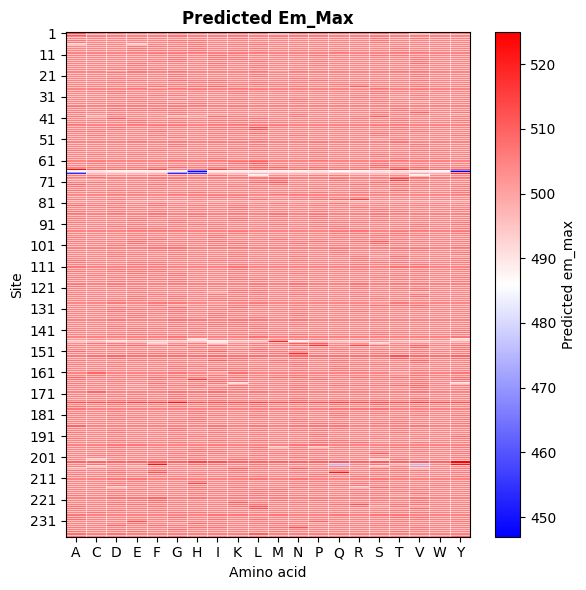

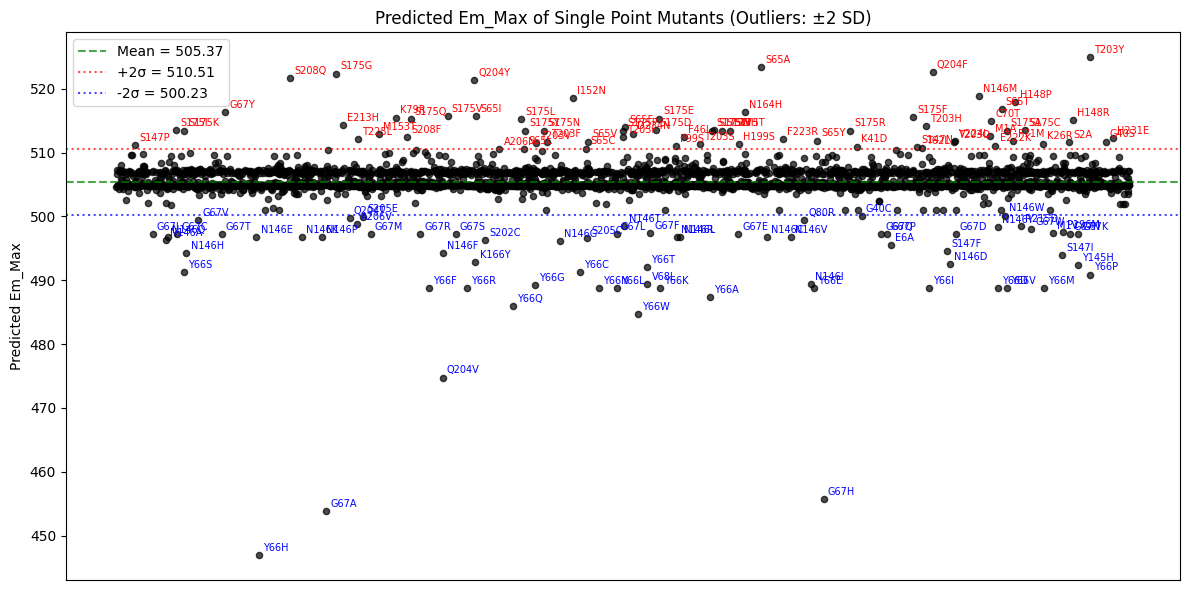

In [5]:
"""
Greedy single-site mutation scan WITHOUT retraining:
- prints ALL mutations with predicted value and delta vs baseline
- builds heatmap (AA on X, site on Y) with white gridlines
- builds jitter scatter of all mutant predictions with ±Nσ outliers annotated

This cell is standalone (does not depend on variables from your reference script).
It will use the in-memory trained model if available; otherwise it loads from a saved bundle.
"""

#@markdown ---
#@markdown #Run Global Amino Acid Search Here
#@markdown ---

import os
import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

# ----------------------------
# User inputs for this cell
# ----------------------------
TEMPLATE_SEQ = (
    "MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"
)

# If you trained in a prior cell, TRAINED_MODEL_PATH will exist; otherwise set a path here.
MODEL_PATH = globals().get("TRAINED_MODEL_PATH", "models/fp_stokes_shift_parent6100.pt")

# Use the canonical alphabet unless the bundle contains a different one
DEFAULT_ALPHABET = "ACDEFGHIKLMNPQRSTVWY"

# Outlier annotation parameters for scatter plot
N_STD = 2  # annotate points beyond mean ± N_STD*std
JITTER = 0.20

# Heatmap look (optional)
HEATMAP_FIGSIZE = (6, 6)
HEATMAP_FACE = "w"   # background like your reference
HEATMAP_CMAP = "bwr"       # diverging like reference

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------------------
# Model + encoding definitions
# ----------------------------
def one_hot_encode_sequence(seq: str, max_len: int, alphabet: str) -> np.ndarray:
    aa_to_idx = {aa: i for i, aa in enumerate(alphabet)}
    arr = np.zeros((max_len, len(alphabet)), dtype=np.float32)
    for i, aa in enumerate(seq[:max_len]):
        idx = aa_to_idx.get(aa)
        if idx is not None:
            arr[i, idx] = 1.0
    return arr

class PropertyPredictor(nn.Module):
    def __init__(self, input_len: int, alphabet_size: int, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_len * alphabet_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

def load_model_bundle(path: str, device: str = "cpu"):
    bundle = torch.load(path, map_location=device)
    max_len = int(bundle["max_len"])
    alphabet = str(bundle.get("amino_alphabet", DEFAULT_ALPHABET))
    property_name = str(bundle.get("property_name", "property"))
    hidden_dim = int(bundle.get("hidden_dim", 64))

    model = PropertyPredictor(input_len=max_len, alphabet_size=len(alphabet), hidden_dim=hidden_dim).to(device)
    model.load_state_dict(bundle["state_dict"])
    model.eval()
    return model, max_len, alphabet, property_name

# ----------------------------
# Acquire model WITHOUT training
# ----------------------------
if "TRAINED_MODEL" in globals() and "TRAINED_MAX_LEN" in globals() and "TRAINED_ALPHABET" in globals():
    model = globals()["TRAINED_MODEL"].to(DEVICE)
    max_len = int(globals()["TRAINED_MAX_LEN"])
    alphabet = str(globals()["TRAINED_ALPHABET"])
    property_name = str(globals().get("TRAINED_PROPERTY", "property"))
    model.eval()
    print("Using in-memory trained model.")
else:
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(
            f"MODEL_PATH not found: {MODEL_PATH}\n"
            "Run your training cell first (to create the bundle), or set MODEL_PATH to an existing .pt bundle."
        )
    model, max_len, alphabet, property_name = load_model_bundle(MODEL_PATH, device=DEVICE)
    print(f"Loaded model bundle from: {MODEL_PATH}")

# ----------------------------
# Baseline prediction
# ----------------------------
template_enc = one_hot_encode_sequence(TEMPLATE_SEQ, max_len, alphabet)
template_tensor = torch.tensor(template_enc, dtype=torch.float32).unsqueeze(0).to(DEVICE)
with torch.no_grad():
    baseline_pred = float(model(template_tensor).squeeze().item())

print(f"\nTemplate predicted {property_name}: {baseline_pred:.6f}\n")

# ----------------------------
# Greedy single-site scan (PRINT ALL MUTATIONS)
# ----------------------------
mutant_predictions = {}  # label -> predicted
mutant_deltas = {}       # label -> pred - baseline

n_pos = len(TEMPLATE_SEQ)

for pos0, orig_aa in enumerate(TEMPLATE_SEQ):
    site = pos0 + 1
    for new_aa in alphabet:
        if new_aa == orig_aa:
            continue
        mutated_seq = TEMPLATE_SEQ[:pos0] + new_aa + TEMPLATE_SEQ[pos0+1:]

        enc = one_hot_encode_sequence(mutated_seq, max_len, alphabet)
        x = torch.tensor(enc, dtype=torch.float32).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            pred = float(model(x).squeeze().item())

        label = f"{orig_aa}{site}{new_aa}"
        delta = pred - baseline_pred

        mutant_predictions[label] = pred
        mutant_deltas[label] = delta

        # Print all mutations (as requested)
        print(f"{label}: predicted {property_name} = {pred:.6f}   Δ={delta:+.6f}")

print(f"\nTotal mutants evaluated: {len(mutant_predictions)}")

# ----------------------------
# Build a DataFrame matrix for heatmap
# rows = sites, cols = amino acids (new residue)
# values = predicted property (not delta) for that substitution
# ----------------------------
pattern = re.compile(r"^([A-Z])(\d+)([A-Z])$")
records = []
site_set = set()

for k, v in mutant_predictions.items():
    m = pattern.match(k)
    if not m:
        continue
    _, pos_s, newaa = m.groups()
    pos = int(pos_s)
    records.append((pos, newaa, float(v)))
    site_set.add(pos)

aa_order = list(alphabet)
site_order = sorted(site_set)

df = pd.DataFrame(index=site_order, columns=aa_order, dtype=float)
for pos, newaa, val in records:
    if (pos in df.index) and (newaa in df.columns):
        df.loc[pos, newaa] = val

# Fill NaNs (should only be identity AAs which we skipped) with per-row min for display
filled = df.copy()
if filled.isna().any().any():
    row_mins = filled.min(axis=1)
    for r in filled.index:
        filled.loc[r] = filled.loc[r].fillna(row_mins[r])

# ----------------------------
# HEATMAP FIGURE (like your reference)
# ----------------------------
plt.figure(figsize=HEATMAP_FIGSIZE, facecolor=HEATMAP_FACE)
ax = plt.gca()
ax.set_facecolor(HEATMAP_FACE)

# IMPORTANT: origin="upper" puts site 1 at the top
im = ax.imshow(
    filled.values,
    aspect="auto",
    cmap=HEATMAP_CMAP,
    interpolation="nearest",
    origin="upper"
)

# X ticks: amino acids
ax.set_xticks(np.arange(len(aa_order)))
ax.set_xticklabels(aa_order)

# Y ticks every 10 residues (matching your reference)
ytick_step = 10
ytick_idx = np.arange(0, len(site_order), ytick_step)
ax.set_yticks(ytick_idx)
ax.set_yticklabels([site_order[i] for i in ytick_idx])

# White gridlines around every cell
ax.set_xticks(np.arange(-0.5, len(aa_order), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(site_order), 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=0.4)
ax.tick_params(which="minor", bottom=False, left=False)

# Labels and title
ax.set_xlabel("Amino acid")
ax.set_ylabel("Site")
ax.set_title(f"Predicted {property_name.title()}", fontweight="bold")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(f"Predicted {property_name}")

plt.tight_layout()
plt.show()

# ----------------------------
# JITTER SCATTER FIGURE (outliers annotated) + delta available in export
# ----------------------------
sorted_items = sorted(mutant_predictions.items(), key=lambda x: x[1], reverse=True)
mut_labels = [k for k, _ in sorted_items]
pred_vals = np.array([v for _, v in sorted_items], dtype=float)
delta_vals = np.array([mutant_deltas[k] for k in mut_labels], dtype=float)

mean_val = float(pred_vals.mean())
std_val = float(pred_vals.std(ddof=0))
upper = mean_val + N_STD * std_val
lower = mean_val - N_STD * std_val

x_jitter = np.random.uniform(-JITTER, JITTER, size=len(pred_vals))
x_positions = x_jitter  # centered at 0

plt.figure(figsize=(12, 6), facecolor="w")
ax = plt.gca()
ax.set_facecolor("w")

plt.scatter(x_positions, pred_vals, s=20, alpha=0.7, color = 'k')

# Annotate outliers beyond ±Nσ
for xi, yi, label in zip(x_positions, pred_vals, mut_labels):
    if yi > upper or yi < lower:
        plt.annotate(
            label,
            (xi, yi),
            textcoords="offset points",
            xytext=(3, 3),
            ha="left",
            fontsize=7,
            color="red" if yi > upper else "blue",
        )

plt.axhline(mean_val, linestyle="--", alpha=0.7, label=f"Mean = {mean_val:.2f}", color = 'green')
plt.axhline(upper, linestyle=":", alpha=0.7, label=f"+{N_STD}σ = {upper:.2f}", color = 'red')
plt.axhline(lower, linestyle=":", alpha=0.7, label=f"-{N_STD}σ = {lower:.2f}", color = 'blue')
plt.legend()

plt.ylabel(f"Predicted {property_name.title()}")
plt.title(f"Predicted {property_name.title()} of Single Point Mutants (Outliers: ±{N_STD} SD)")
plt.grid(False)
plt.xticks([])  # hide meaningless x-axis
plt.tight_layout()
plt.show()

# ----------------------------
# Optional: export ALL mutations with prediction + delta
# ----------------------------
out_df = pd.DataFrame({
    "mutation": mut_labels,
    "predicted": pred_vals,
    "delta_vs_template": delta_vals,
}).sort_values("predicted", ascending=False)

csv_name = f"all_single_mutants_{property_name}.csv"
# out_df.to_csv(csv_name, index=False)
# print(f"\nWrote full table (all mutations) to: {csv_name}")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PARENT_ORGANISM = 6100

# Exclude protein names containing any of these substrings
EXCLUDE_TERMS = ("channelrhodopsin", "rcamp", "gcamp2", "cp-mkate", "cegfp")

# Amino acid alphabet for one‑hot encoding
AMINO_ALPHABET = "ACDEFGHIKLMNPQRSTVWY"




# -----------------------------------------------------------------------------
def fetch_fpbase_proteins(parent_organism: int) -> list:
    """Retrieve proteins for a given parent organism from the FPbase API.

    Parameters
    ----------
    parent_organism : int
        Numeric identifier for the organism.  For example, 6100 corresponds
        to fluorescent proteins derived from Discosoma sp.

    Returns
    -------
    list of dict
        A list of protein objects as returned by the API.
    """
    proteins: list = []
    # url = f"https://www.fpbase.org/api/proteins/?parent_organism={parent_organism}&format=json"
    url = f"https://www.fpbase.org/api/proteins/?&format=json"

    while url:
        print(f"Fetching {url} …")
        resp = requests.get(url)
        resp.raise_for_status()
        data = resp.json()
        if isinstance(data, list):
            proteins.extend(data)
            break
        results = data.get("results", [])
        proteins.extend(results)
        url = data.get("next")
    return proteins

In [ ]:
def save_trained_bundle(
    path: str,
    model,
    *,
    max_len: int,
    amino_alphabet: str,
    property_name: str
):
    """
    Save everything needed to reload the model and run inference later without retraining.
    """
    bundle = {
        "state_dict": model.state_dict(),
        "max_len": int(max_len),
        "amino_alphabet": amino_alphabet,
        "property_name": property_name,
        "model_kwargs": {
            "input_len": int(max_len),
            "alphabet_size": int(len(amino_alphabet)),
        },
    }
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    torch.save(bundle, path)

def load_trained_bundle(path: str, model_cls, device: str = "cpu"):
    """
    Load a saved model and return (model, bundle dict).
    """
    bundle = torch.load(path, map_location=device)
    model = model_cls(**bundle["model_kwargs"])
    model.load_state_dict(bundle["state_dict"])
    model.eval()
    return model.to(device), bundle

In [ ]:
"""
This script trains fluorescent protein property prediction models for one or more properties.

It mirrors the existing `main()` training loop that trains a single-property model but
allows the caller to specify multiple properties to train sequentially. For each property,
the script will:

  * Fetch and filter FPbase sequences using `fetch_fpbase_proteins` and `EXCLUDE_TERMS`.
  * Build one-hot encoded input tensors based on `AMINO_ALPHABET`.
  * Train an instance of `PropertyPredictor` on the selected property using mean squared
    error as the loss function.
  * Save the trained model bundle to disk via `save_trained_bundle`.
  * Optionally plot the training loss history.

Assumptions:
  - Functions `fetch_fpbase_proteins`, `extract_property`, `one_hot_encode_sequence`,
    the `PropertyPredictor` class, and constants `PARENT_ORGANISM`, `EXCLUDE_TERMS`,
    `AMINO_ALPHABET` exist in the environment that imports this module.
  - Functions `save_trained_bundle` and `load_trained_bundle` are also available in
    the environment. These are used to save and reload trained model bundles.

Example usage:

    from train_fp_properties import train_fp_properties

    # train brightness and pKa models, forcing retrain and using GPU if available
    results = train_fp_properties(
        property_names=["brightness", "pka"],
        input_seq=my_sequence,
        epochs=3000,
        force_retrain=True,
        model_dir="models",
        device="cuda" if torch.cuda.is_available() else "cpu",
        make_plots=True,
    )

"""

from typing import Iterable, Dict, Tuple, List
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import trange

# Ensure required helpers and constants exist in the importing namespace. If any of
# these are missing, a NameError will be raised when this module is imported. The
# caller should define or import these before importing this module.
try:
    fetch_fpbase_proteins  # type: ignore[name-defined]
    extract_property  # type: ignore[name-defined]
    one_hot_encode_sequence  # type: ignore[name-defined]
    PropertyPredictor  # type: ignore[name-defined]
    PARENT_ORGANISM  # type: ignore[name-defined]
    EXCLUDE_TERMS  # type: ignore[name-defined]
    AMINO_ALPHABET  # type: ignore[name-defined]
    save_trained_bundle  # type: ignore[name-defined]
    load_trained_bundle  # type: ignore[name-defined]
except NameError as e:
    raise ImportError(
        "Required helper functions or constants are not defined in the importing namespace: "
        f"{e}"
    )

from pathlib import Path
import torch





def _predict_sequence_local(
    model: torch.nn.Module,
    seq: str,
    max_len: int,
    alphabet: str,
    device: str,
) -> float:
    """
    Local helper to predict a scalar property for a single sequence using the trained model.
    This function does not rely on any external helper and uses the local encoding.

    Args:
        model: Trained PyTorch model that accepts (batch, L, A) inputs and outputs (batch, 1).
        seq: Amino acid sequence to encode.
        max_len: Maximum length used for training (for padding/truncation).
        alphabet: String representing the alphabet order used during training.
        device: Device string (e.g. "cpu" or "cuda") where the model resides.

    Returns:
        A single float prediction for the provided sequence.
    """
    enc = one_hot_encode_sequence(seq, max_len, alphabet)  # type: ignore[name-defined]
    x = torch.tensor(enc, dtype=torch.float32).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        return float(model(x).squeeze().item())


def _train_single_property(
    property_name: str,
    *,
    input_seq: str,
    epochs: int,
    force_retrain: bool,
    model_dir: str,
    device: str,
    make_plots: bool,
) -> Tuple[
    torch.nn.Module,
    int,
    torch.Tensor,
    torch.Tensor,
    np.ndarray,
    float,
]:
    """
    Train or load a model for a single FP property.

    Args:
        property_name: Property to train on (e.g. "brightness", "pka").
        input_seq: Sequence used for immediate prediction after training.
        epochs: Number of training epochs.
        force_retrain: If True, ignore any saved model and retrain from scratch.
        model_dir: Directory where the model bundle is saved/loaded.
        device: Target device for training ("cpu" or "cuda").
        make_plots: If True, plot the training loss history.

    Returns:
        A tuple containing:
          - The trained model
          - The maximum sequence length used for encoding
          - The tensor of one-hot encoded training sequences
          - The tensor of training labels
          - A numpy array of model predictions on the training set
          - The model's prediction for the provided input_seq
    """
    # Ensure model directory exists
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f"fp_{property_name}.pt")

    # If a saved model exists and retrain is not forced, load and return predictions
    if not force_retrain and os.path.exists(model_path):
        model, bundle = load_trained_bundle(model_path, PropertyPredictor, device=device)  # type: ignore[name-defined]
        max_len = int(bundle["max_len"])
        amino_alphabet = bundle["amino_alphabet"]

        input_pred = _predict_sequence_local(model, input_seq, max_len, amino_alphabet, device)

        # Rebuild training data for evaluation and plotting
        proteins = fetch_fpbase_proteins(parent_organism=PARENT_ORGANISM)  # type: ignore[name-defined]
        proteins = [
            p
            for p in proteins
            if not any(term in (p.get("name") or "").lower() for term in EXCLUDE_TERMS)  # type: ignore[name-defined]
        ]
        samples: List[Tuple[str, float]] = []
        for protein in proteins:
            seq = protein.get("seq")
            val = extract_property(protein, property_name)  # type: ignore[name-defined]
            if seq and val is not None:
                try:
                    samples.append((seq, float(val)))
                except Exception:
                    pass
        if not samples:
            raise RuntimeError(
                f"No valid samples retrieved for property '{property_name}' when loading model."
            )
        X = np.stack([
            one_hot_encode_sequence(seq, max_len, amino_alphabet)  # type: ignore[name-defined]
            for seq, _ in samples
        ])
        y = np.array([val for _, val in samples], dtype=np.float32)
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)
        model.eval()
        with torch.no_grad():
            preds = model(X_tensor).squeeze().detach().cpu().numpy()
        return model, max_len, X_tensor, y_tensor, preds, input_pred

    # Otherwise train from scratch
    proteins = fetch_fpbase_proteins(parent_organism=PARENT_ORGANISM)  # type: ignore[name-defined]
    proteins = [
        p
        for p in proteins
        if not any(term in (p.get("name") or "").lower() for term in EXCLUDE_TERMS)  # type: ignore[name-defined]
    ]
    samples: List[Tuple[str, float]] = []
    for protein in proteins:
        seq = protein.get("seq")
        val = extract_property(protein, property_name)  # type: ignore[name-defined]
        if seq and val is not None:
            try:
                samples.append((seq, float(val)))
            except Exception:
                pass
    if not samples:
        raise RuntimeError(f"No valid samples retrieved for property '{property_name}'.")

    max_len = max(len(seq) for seq, _ in samples)
    X = np.stack(
        [one_hot_encode_sequence(seq, max_len, AMINO_ALPHABET)  # type: ignore[name-defined]
         for seq, _ in samples]
    )
    y = np.array([val for _, val in samples], dtype=np.float32)
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)

    model = PropertyPredictor(
        input_len=max_len,
        alphabet_size=len(AMINO_ALPHABET),
    ).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    pbar = trange(
        epochs,
        desc=f"Training {property_name}",
        unit="epoch",
        leave=True,
        colour="cyan",
        bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [ETA {remaining}] {postfix}",
    )
    loss_history: List[float] = []
    for _ in pbar:
        model.train()
        optimizer.zero_grad()
        preds = model(X_tensor)
        loss = criterion(preds, y_tensor)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        pbar.set_postfix_str(f"loss={loss.item():.3f}", refresh=True)

    # Save the trained model bundle for future use
    save_trained_bundle(
        model_path,
        model,
        max_len=max_len,
        amino_alphabet=AMINO_ALPHABET,  # type: ignore[name-defined]
        property_name=property_name,
    )

    # Evaluate on the full training set for later analysis
    model.eval()
    with torch.no_grad():
        predictions = model(X_tensor).squeeze().detach().cpu().numpy()

    # Predict the property for the provided sequence
    input_pred = _predict_sequence_local(
        model,
        input_seq,
        max_len,
        AMINO_ALPHABET,  # type: ignore[name-defined]
        device,
    )

    # Optionally plot training loss
    if make_plots:
        plt.figure(figsize=(7, 4))
        plt.plot(range(1, epochs + 1), loss_history)
        plt.xlabel("Epoch")
        plt.ylabel("Training Loss (MSE)")
        plt.title(f"Training Loss for {property_name}")
        plt.tight_layout()
        plt.show()

    return model, max_len, X_tensor, y_tensor, predictions, input_pred


def train_fp_properties(
    property_names: Iterable[str],
    *,
    input_seq: str,
    epochs: int = 5000,
    force_retrain: bool = False,
    model_dir: str = "models",
    device: str = "cpu",
    make_plots: bool = False,
) -> Dict[str, Tuple[torch.nn.Module, int, torch.Tensor, torch.Tensor, np.ndarray, float]]:
    """
    Train (or load) models for a list of fluorescent protein properties.

    This function is a convenience wrapper that iterates over `property_names`, calling
    the single-property training routine for each. It returns a dictionary of results.

    Args:
        property_names: Iterable of property names to train (e.g., ["brightness", "pka"]).
        input_seq: Amino acid sequence to evaluate immediately after training each model.
        epochs: Number of epochs to train each model. Default is 5000.
        force_retrain: If True, ignore existing saved models and retrain from scratch for
            each property.
        model_dir: Directory where model bundles will be saved and loaded from.
        device: Device string ("cpu" or "cuda"). If "cuda" is specified but not
            available, training will fall back to CPU silently.
        make_plots: Whether to produce a training loss plot for each property.

    Returns:
        A dictionary keyed by property name. Each value is the tuple returned by
        `_train_single_property` containing: (model, max_len, X_tensor, y_tensor,
        predictions_on_training_set, input_prediction).

    Notes:
        If you specify a large list of properties and large numbers of epochs, the
        training may take significant time. Consider lowering `epochs` or disabling
        plots for quicker experimentation.
    """
    results: Dict[str, Tuple[
        torch.nn.Module,
        int,
        torch.Tensor,
        torch.Tensor,
        np.ndarray,
        float,
    ]] = {}
    # Normalize device selection: if CUDA is requested but unavailable, use CPU
    device = device if (device == "cuda" and torch.cuda.is_available()) else "cpu"
    for prop in property_names:
        print(f"=== Training model for property: {prop} ===")
        results[prop] = _train_single_property(
            prop,
            input_seq=input_seq,
            epochs=epochs,
            force_retrain=force_retrain,
            model_dir=model_dir,
            device=device,
            make_plots=make_plots,
        )
        print(f"=== Completed training for property: {prop}\n")
    return results

In [ ]:
property_names = ["brightness", "ex_max", "em_max", 'pka']
results = train_fp_properties(
    property_names=property_names,
    input_seq=Fluorescent_Protein_Seq,
    force_retrain=True,
    model_dir="/content/drive/MyDrive/PyTorch/PyTorch_Training_Data",
    epochs=20000,
    device="cuda",
    make_plots=False
)

=== Training model for property: brightness ===
Fetching https://www.fpbase.org/api/proteins/?&format=json …


Training brightness:   0%|          | 0/20000 [ETA ?] 

In [ ]:
import os
import re
import pandas as pd
import torch
import numpy as np

# ------------- CONFIGURATION -------------
OUTPUT_PATH = '/content/drive/MyDrive/PyTorch/PyTorch_Output_Data'
FASTA_PATH = "/content/drive/MyDrive/Machine_Learning_FP_Evolution/EGFP_Ex_Max_Reverse_Evolved_Sequences_From_ML.fasta"
MODEL_DIR = "/content/drive/MyDrive/PyTorch/PyTorch_Training_Data"
PROPERTY_NAMES = ["brightness", "pka", "ex_max", "em_max",]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# ---------- REQUIRED DEFINITIONS ----------
# Ensure these exist in your notebook runtime:
# - PropertyPredictor class (same architecture used during training)
# - one_hot_encode_sequence(seq, max_len, alphabet)
# If they are not in scope, import them or paste their definitions here.

def load_trained_bundle(path: str, model_cls, device: str = "cpu"):
    """
    Load a saved model and return (model, bundle dict).
    """
    bundle = torch.load(path, map_location=device)
    model = model_cls(**bundle["model_kwargs"])
    model.load_state_dict(bundle["state_dict"])
    model.eval()
    return model.to(device), bundle

def read_fasta(path: str):
    """
    Returns a list of dicts: {"id":..., "desc":..., "seq":...} for each record.
    """
    records = []
    with open(path, "r") as f:
        seq_id, desc, buf = None, "", []
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if seq_id is not None:
                    records.append({"id": seq_id, "desc": desc, "seq": "".join(buf)})
                header = line[1:]
                parts = header.split(None, 1)
                seq_id = parts[0]
                desc = parts[1] if len(parts) > 1 else ""
                buf = []
            else:
                buf.append(line)
        if seq_id is not None:
            records.append({"id": seq_id, "desc": desc, "seq": "".join(buf)})
    return records

def sanitize_seq(seq: str):
    """Remove whitespace and uppercase a sequence."""
    return re.sub(r"\s+", "", (seq or "").upper())

def predict_property(model, seq: str, *, max_len: int, alphabet: str):
    """
    Encode a sequence and produce a scalar prediction.
    """
    enc = one_hot_encode_sequence(seq, max_len, alphabet)  # (max_len, alphabet_size)
    x = torch.tensor(enc, dtype=torch.float32).unsqueeze(0).to(next(model.parameters()).device)
    model.eval()
    with torch.no_grad():
        return float(model(x).squeeze().item())

# ---------- LOAD ALL MODELS ----------
# Each property gets its own model and encoding parameters.
models_info = {}
for prop in PROPERTY_NAMES:
    path = os.path.join(MODEL_DIR, f"fp_{prop}.pt")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model file not found for {prop}: {path}")
    model, bundle = load_trained_bundle(path, PropertyPredictor, device=DEVICE)
    models_info[prop] = {
        "model": model,
        "max_len": int(bundle["max_len"]),
        "alphabet": bundle["amino_alphabet"],
    }
    print(f"Loaded {prop} model with max_len={models_info[prop]['max_len']}")

# ---------- READ FASTA ----------
records = read_fasta(FASTA_PATH)
if not records:
    raise RuntimeError(f"No FASTA records found in {FASTA_PATH}")
print("Number of sequences:", len(records))

# ---------- PREDICT FOR ALL PROPERTIES ----------
rows = []
for rec in records:
    seq_raw = sanitize_seq(rec["seq"])
    row = {
        "id": rec["id"],
        "desc": rec["desc"],
        "seq_len": len(seq_raw),
        "sequence": seq_raw,
    }
    # Track unknown/truncated characters per model (optional)
    for prop in PROPERTY_NAMES:
        info = models_info[prop]
        alphabet_set = set(info["alphabet"])
        max_len = info["max_len"]
        row[f"unknown_{prop}"] = sum(1 for ch in seq_raw if ch not in alphabet_set)
        row[f"trunc_{prop}"] = max(0, len(seq_raw) - max_len)
        pred = predict_property(
            info["model"],
            seq_raw,
            max_len=max_len,
            alphabet=info["alphabet"],
        )
        row[f"pred_{prop}"] = pred
    rows.append(row)

# ---------- BUILD DATAFRAME ----------
df = pd.DataFrame(rows)

# Example: sort by brightness descending
df_sorted = df.sort_values(by="pred_brightness", ascending=False).reset_index(drop=True)

# print(df_sorted.head(10)[["id", "seq_len"] + [f"pred_{p}" for p in PROPERTY_NAMES]])
# Save to CSV if desired
fasta_base = os.path.splitext(os.path.basename(FASTA_PATH))[0]

out_csv = os.path.join(OUTPUT_PATH,fasta_base + "_ANN_predictions_multi_parameters.csv")
df_sorted.to_csv(out_csv, index=False)
print("Saved predictions:", out_csv)


Using device: cpu
Loaded brightness model with max_len=582
Loaded pka model with max_len=486
Loaded ex_max model with max_len=582
Loaded em_max model with max_len=582
Number of sequences: 293
Saved predictions: /content/drive/MyDrive/PyTorch/PyTorch_Output_Data/EGFP_Ex_Max_Reverse_Evolved_Sequences_From_ML_ANN_predictions_multi_parameters.csv


In [ ]:
import os
import re
import pandas as pd
import torch
import numpy as np

# ------------- CONFIGURATION -------------
OUTPUT_PATH = '/content/drive/MyDrive/PyTorch/PyTorch_Output_Data'
FASTA_DIR = "/content/drive/MyDrive/Machine_Learning_FP_Evolution"
MODEL_DIR = "/content/drive/MyDrive/PyTorch/PyTorch_Training_Data"
PROPERTY_NAMES = ["brightness", "pka", "ex_max", "em_max",]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

os.makedirs(OUTPUT_PATH, exist_ok=True)

# Collect all fasta-like files in the directory
fasta_files = [
    os.path.join(FASTA_DIR, f)
    for f in os.listdir(FASTA_DIR)
    if f.lower().endswith((".fasta", ".fa", ".faa"))
]
print("Found FASTA files:", len(fasta_files))

# ---------- REQUIRED DEFINITIONS ----------
# Ensure these exist in your notebook runtime:
# - PropertyPredictor class (same architecture used during training)
# - one_hot_encode_sequence(seq, max_len, alphabet)

def load_trained_bundle(path: str, model_cls, device: str = "cpu"):
    """
    Load a saved model and return (model, bundle dict).
    """
    bundle = torch.load(path, map_location=device)
    model = model_cls(**bundle["model_kwargs"])
    model.load_state_dict(bundle["state_dict"])
    model.eval()
    return model.to(device), bundle

def read_fasta(path: str):
    """
    Returns a list of dicts: {"id":..., "desc":..., "seq":...} for each record.
    """
    records = []
    with open(path, "r") as f:
        seq_id, desc, buf = None, "", []
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if seq_id is not None:
                    records.append({"id": seq_id, "desc": desc, "seq": "".join(buf)})
                header = line[1:]
                parts = header.split(None, 1)
                seq_id = parts[0]
                desc = parts[1] if len(parts) > 1 else ""
                buf = []
            else:
                buf.append(line)
        if seq_id is not None:
            records.append({"id": seq_id, "desc": desc, "seq": "".join(buf)})
    return records

def sanitize_seq(seq: str):
    """Remove whitespace and uppercase a sequence."""
    return re.sub(r"\s+", "", (seq or "").upper())

def predict_property(model, seq: str, *, max_len: int, alphabet: str):
    """
    Encode a sequence and produce a scalar prediction.
    """
    enc = one_hot_encode_sequence(seq, max_len, alphabet)  # (max_len, alphabet_size)
    x = torch.tensor(enc, dtype=torch.float32).unsqueeze(0).to(next(model.parameters()).device)
    model.eval()
    with torch.no_grad():
        return float(model(x).squeeze().item())

# ---------- LOAD ALL MODELS ----------
# Each property gets its own model and encoding parameters.
models_info = {}
for prop in PROPERTY_NAMES:
    path = os.path.join(MODEL_DIR, f"fp_{prop}.pt")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model file not found for {prop}: {path}")
    model, bundle = load_trained_bundle(path, PropertyPredictor, device=DEVICE)
    models_info[prop] = {
        "model": model,
        "max_len": int(bundle["max_len"]),
        "alphabet": bundle["amino_alphabet"],
    }
    print(f"Loaded {prop} model with max_len={models_info[prop]['max_len']}")

# ---------- LOOP OVER ALL FASTA FILES ----------
for FASTA_PATH in sorted(fasta_files):

    # ---------- READ FASTA ----------
    records = read_fasta(FASTA_PATH)
    if not records:
        print(f"Skipping empty FASTA: {FASTA_PATH}")
        continue
    print("\nScoring:", FASTA_PATH)
    print("Number of sequences:", len(records))

    # ---------- PREDICT FOR ALL PROPERTIES ----------
    rows = []
    for rec in records:
        seq_raw = sanitize_seq(rec["seq"])
        row = {
            "id": rec["id"],
            "desc": rec["desc"],
            "seq_len": len(seq_raw),
            "sequence": seq_raw,
        }
        # Track unknown/truncated characters per model (optional)
        for prop in PROPERTY_NAMES:
            info = models_info[prop]
            alphabet_set = set(info["alphabet"])
            max_len = info["max_len"]
            row[f"unknown_{prop}"] = sum(1 for ch in seq_raw if ch not in alphabet_set)
            row[f"trunc_{prop}"] = max(0, len(seq_raw) - max_len)
            pred = predict_property(
                info["model"],
                seq_raw,
                max_len=max_len,
                alphabet=info["alphabet"],
            )
            row[f"pred_{prop}"] = pred
        rows.append(row)

    # ---------- BUILD DATAFRAME ----------
    df = pd.DataFrame(rows)

    # Example: sort by brightness descending
    df_sorted = df.sort_values(by="pred_brightness", ascending=False).reset_index(drop=True)

    # ---------- SAVE TO CSV ----------
    fasta_base = os.path.splitext(os.path.basename(FASTA_PATH))[0]
    out_csv = os.path.join(OUTPUT_PATH, fasta_base + "_ANN_predictions_multi_parameters.csv")
    df_sorted.to_csv(out_csv, index=False)
    print("Saved predictions:", out_csv)


Using device: cpu
Found FASTA files: 87
Loaded brightness model with max_len=582
Loaded pka model with max_len=486
Loaded ex_max model with max_len=582
Loaded em_max model with max_len=582

Scoring: /content/drive/MyDrive/Machine_Learning_FP_Evolution/EGFP_Brightness_Evolved_Sequences_From_ML.fasta
Number of sequences: 693
Saved predictions: /content/drive/MyDrive/PyTorch/PyTorch_Output_Data/EGFP_Brightness_Evolved_Sequences_From_ML_ANN_predictions_multi_parameters.csv

Scoring: /content/drive/MyDrive/Machine_Learning_FP_Evolution/EGFP_Em_Max_Evolved_Sequences_From_ML.fasta
Number of sequences: 31
Saved predictions: /content/drive/MyDrive/PyTorch/PyTorch_Output_Data/EGFP_Em_Max_Evolved_Sequences_From_ML_ANN_predictions_multi_parameters.csv

Scoring: /content/drive/MyDrive/Machine_Learning_FP_Evolution/EGFP_Ex_Max_Evolved_Sequences_From_ML.fasta
Number of sequences: 49
Saved predictions: /content/drive/MyDrive/PyTorch/PyTorch_Output_Data/EGFP_Ex_Max_Evolved_Sequences_From_ML_ANN_predict